In [1]:
#!pip install --user logomaker

In [1]:
from Bio import SeqIO
import gzip
import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
from scipy.stats import entropy
import seaborn as sns
from io import StringIO

In [2]:
nucleotides = ["A", "C", "G", "T"]

In [3]:
with gzip.open("../../data/mlm/genome/Arabidopsis_thaliana.fa.gz", "rt") as handle:
    genome = SeqIO.to_dict(SeqIO.parse(handle, "fasta"))
genome = {k: v.upper() for k, v in genome.items()}
genome

{'1': SeqRecord(seq=Seq('CCCTAAACCCTAAACCCTAAACCCTAAACCTCTGAATCCTTAATCCCTAAATCC...GGG'), id='1', name='1', description='1 dna_sm:chromosome chromosome:TAIR10:1:1:30427671:1 REF', dbxrefs=[]),
 '2': SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...GGG'), id='2', name='2', description='2 dna_sm:chromosome chromosome:TAIR10:2:1:19698289:1 REF', dbxrefs=[]),
 '3': SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...CCC'), id='3', name='3', description='3 dna_sm:chromosome chromosome:TAIR10:3:1:23459830:1 REF', dbxrefs=[]),
 '4': SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...AGG'), id='4', name='4', description='4 dna_sm:chromosome chromosome:TAIR10:4:1:18585056:1 REF', dbxrefs=[]),
 '5': SeqRecord(seq=Seq('TATACCATGTACCCTCAACCTTAAAACCCTAAAACCTATACTATAAATCTTTAA...ATC'), id='5', name='5', description='5 dna_sm:chromosome chromosome:TAIR10:5:1:26975502:1 REF', dbxrefs=[]),
 'Mt': SeqRecord(seq=Seq('GGATCCGTTCGAAA

In [26]:
string = str(genome['5'][3500000:3600000].seq)
import re
[m.start() for m in re.finditer('AAACCCTAA', string)]

In [4]:
#coordinates = "Chr5:3564493-3565087"
#coordinates = "Chr5:552887-553012"
coordinates = "Chr5:3500000-3600000"
start = int(coordinates.split(":")[1].split("-")[0])
end = int(coordinates.split(":")[1].split("-")[1])

df = pd.read_parquet(f"results/logits/logits_{coordinates}.parquet")
df["ref_nuc"] = df.apply(lambda row: genome[row.chromosome[-1]][row.pos], axis=1)
df.set_index("pos", inplace=True, drop=False)
for nucleotide in nucleotides:
    df[f"llr_{nucleotide}"] = df.apply(lambda row: row[nucleotide]-row[row.ref_nuc], axis=1)
df.loc[:, nucleotides] = softmax(df[nucleotides].values, axis=1)
for nucleotide in nucleotides:
    df[f"ref_1hot_{nucleotide}"] = df.apply(lambda row: 1.0 if row.ref_nuc==nucleotide else 0.0, axis=1)

    
def entropy(p):
    return -np.sum(p*np.log2(p), axis=1)


def cross_entropy(p, q):
    return -np.sum(p*np.log2(q), axis=1)

true_cols = [f"ref_1hot_{nucleotide}" for nucleotide in nucleotides]
pred_cols = nucleotides
df["cross_entropy"] = cross_entropy(df[true_cols].values, df[pred_cols].values)
df["entropy"] = entropy(df[pred_cols].values)
df["cross_perplexity"] = np.exp2(df.cross_entropy)
df["perplexity"] = np.exp2(df.entropy)
df

,pos,chromosome,A,C,G,T,ref_nuc,llr_A,llr_C,llr_G,llr_T,ref_1hot_A,ref_1hot_C,ref_1hot_G,ref_1hot_T,cross_entropy,entropy,cross_perplexity,perplexity
pos,,,,,,,,,,,,,,,,,,,
3500000,3500000,Chr5,0.344579,0.106808,0.278123,0.270490,A,0.000000,-1.171289,-0.214262,-0.242087,1.0,0.0,0.0,0.0,1.537093,1.898022,2.902092,3.727017
3500001,3500001,Chr5,0.410754,0.156371,0.300011,0.132865,C,0.965767,0.000000,0.651589,-0.162898,0.0,1.0,0.0,0.0,2.676959,1.853854,6.395065,3.614645
3500002,3500002,Chr5,0.401194,0.096803,0.149774,0.352229,A,0.000000,-1.421768,-0.985316,-0.130164,1.0,0.0,0.0,0.0,1.317628,1.795238,2.492560,3.470726
3500003,3500003,Chr5,0.222095,0.148082,0.357351,0.272472,G,-0.475614,-0.880956,0.000000,-0.271185,0.0,0.0,1.0,0.0,1.484584,1.931784,2.798366,3.815267
3500004,3500004,Chr5,0.224391,0.330020,0.147175,0.298414,C,-0.385763,0.000000,-0.807531,-0.100670,0.0,1.0,0.0,0.0,1.599375,1.939060,3.030121,3.834557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599995,3599995,Chr5,0.312765,0.091956,0.253395,0.341884,C,1.224146,0.000000,1.013643,1.313163,0.0,1.0,0.0,0.0,3.442917,1.872295,10.874797,3.661146
3599996,3599996,Chr5,0.263469,0.153526,0.392654,0.190351,G,-0.398993,-0.939062,0.000000,-0.724059,0.0,0.0,1.0,0.0,1.348669,1.907162,2.546770,3.750705
3599997,3599997,Chr5,0.231608,0.446558,0.164874,0.156959,T,0.389061,1.045583,0.049197,0.000000,0.0,0.0,0.0,1.0,2.671538,1.856221,6.371079,3.620579


In [11]:
figsize=(6,1.0)
ylabel = "bits"

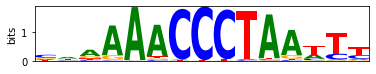

In [12]:
#this one is a good example (TFBS)
min_pos, max_pos = 3582589, 3582603

logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
plt.savefig("logo_tfbs.svg", bbox_inches="tight")

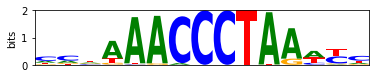

In [17]:
# plotting known motif
# http://planttfdb.gao-lab.org/tf.php?sp=Ath&did=AT1G72740.1
# http://planttfdb.gao-lab.org/motif/Ath/AT1G72740.meme
string = """
0.213058	  0.529210	  0.079038	  0.178694
0.237113	  0.546392	  0.116838	  0.099656
0.202749	  0.158076	  0.175258	  0.463918
0.735395	  0.010309	  0.075601	  0.178694
0.969072	  0.010309	  0.006873	  0.013746
0.969072	  0.000000	  0.030928	  0.000000
0.034364	  0.965636	  0.000000	  0.000000
0.000000	  1.000000	  0.000000	  0.000000
0.000000	  1.000000	  0.000000	  0.000000
0.000000	  0.000000	  0.000000	  1.000000
0.993127	  0.000000	  0.003436	  0.003436
0.831615	  0.000000	  0.168385	  0.000000
0.474227	  0.140893	  0.006873	  0.378007
0.030928	  0.443299	  0.054983	  0.470790
0.127148	  0.539519	  0.092784	  0.240550
"""
true_motif = pd.read_csv(StringIO(string), sep="\t", header=None, names=["A", "C", "G", "T"])
logomaker.Logo(
    logomaker.transform_matrix(true_motif, from_type="probability", to_type="information"),
    figsize=figsize
)
plt.ylabel(ylabel)
plt.xticks([], [])
#plt.tight_layout()
plt.savefig("logo_tfbs_true.svg", bbox_inches="tight")

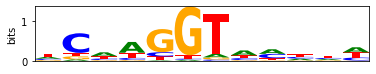

In [13]:
# splice donor
min_pos, max_pos = 3510975, 3510986
logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
plt.savefig("logo_splice_donor.svg", bbox_inches="tight")

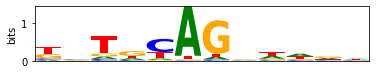

In [15]:
# splice donor
min_pos, max_pos = 3511464,3511475
logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
plt.savefig("logo_splice_acceptor.svg", bbox_inches="tight")

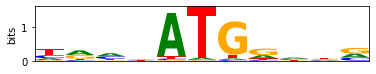

In [16]:
# start codon
min_pos, max_pos = 3598954, 3598964
logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
plt.savefig("logo_start_codon.svg", bbox_inches="tight")

([], [])

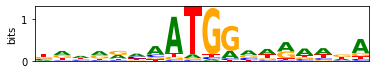

In [19]:
# another start codon, interesting to interpret the AAAA
min_pos, max_pos = 3567381, 3567398
logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
#plt.savefig("logo_start_codon_v2.svg", bbox_inches="tight")

In [38]:
# plotting known motif
# http://planttfdb.gao-lab.org/tf.php?sp=Ath&did=AT1G45249.1
string = """
0.347899	  0.132773	  0.263866	  0.255462
0.467227	  0.134454	  0.161345	  0.236975
0.445378	  0.072269	  0.131092	  0.351261
0.398319	  0.142857	  0.134454	  0.324370
0.309244	  0.231933	  0.184874	  0.273950
0.042017	  0.141176	  0.090756	  0.726050
0.001681	  0.000000	  0.952941	  0.045378
0.292437	  0.707563	  0.000000	  0.000000
0.000000	  1.000000	  0.000000	  0.000000
0.998319	  0.000000	  0.000000	  0.001681
0.000000	  1.000000	  0.000000	  0.000000
0.000000	  0.000000	  1.000000	  0.000000
0.000000	  0.000000	  0.000000	  1.000000
0.033613	  0.423529	  0.542857	  0.000000
0.440336	  0.000000	  0.154622	  0.405042
0.072269	  0.512605	  0.174790	  0.240336
0.218487	  0.638655	  0.048739	  0.094118
0.472269	  0.157983	  0.067227	  0.302521
"""
true_motif = pd.read_csv(StringIO(string), sep="\t", header=None, names=["A", "C", "G", "T"])
logomaker.Logo(
    logomaker.transform_matrix(true_motif, from_type="probability", to_type="information"),
)
plt.ylabel("information (bits)")

SyntaxError: invalid syntax (<ipython-input-38-999eecf49d6b>, line 4)

In [54]:
funtfbs = pd.read_csv("TFBS_from_FunTFBS_genome-wide_Ath.gff", sep="\t", header=None, names=["chromosome", "source1", "source2", "start", "end", "score", "strand", "unknown", "annotation"], usecols=["chromosome", "start", "end", "strand", "annotation"])
funtfbs

,chromosome,start,end,strand,annotation
0,Chr1,1064,1081,-,Name=AT5G62470;ID=AT5G62470_1;correlation=0.53...
1,Chr1,1070,1080,-,Name=AT3G08500;ID=AT3G08500_2;correlation=0.66...
2,Chr1,1428,1438,+,Name=AT5G67450;ID=AT5G67450_3;correlation=0.74...
3,Chr1,2982,2995,-,Name=AT5G41570;ID=AT5G41570_4;correlation=0.53...
4,Chr1,4047,4066,+,Name=AT2G01570;ID=AT2G01570_5;correlation=0.51...
...,...,...,...,...,...
327937,ChrM,361893,361907,-,Name=AT5G51190;ID=AT5G51190_327938;correlation...
327938,ChrM,361895,361909,-,Name=AT5G67000;ID=AT5G67000_327939;correlation...
327939,ChrM,361896,361910,-,Name=AT4G34410;ID=AT4G34410_327940;correlation...
327940,ChrM,361898,361912,+,Name=AT5G07310;ID=AT5G07310_327941;correlation...


In [55]:
funtfbs = funtfbs.query("chromosome == 'Chr5' and start >= 3500000 and end <= 3600000")
funtfbs

,chromosome,start,end,strand,annotation
267053,Chr5,3500583,3500602,-,Name=AT1G71450;ID=AT1G71450_267054;correlation...
267054,Chr5,3500584,3500604,+,Name=AT2G40340;ID=AT2G40340_267055;correlation...
267055,Chr5,3502186,3502206,+,Name=AT4G27950;ID=AT4G27950_267056;correlation...
267056,Chr5,3502188,3502206,-,Name=AT5G25190;ID=AT5G25190_267057;correlation...
267057,Chr5,3502239,3502254,+,Name=AT1G19040;ID=AT1G19040_267058;correlation...
...,...,...,...,...,...
267271,Chr5,3596606,3596626,+,Name=AT3G20310;ID=AT3G20310_267272;correlation...
267272,Chr5,3597413,3597428,+,Name=AT4G01500;ID=AT4G01500_267273;correlation...
267273,Chr5,3597445,3597454,-,Name=AT2G17180;ID=AT2G17180_267274;correlation...
267274,Chr5,3597445,3597454,+,Name=AT2G17180;ID=AT2G17180_267275;correlation...


In [56]:
funtfbs["TF"] = funtfbs.annotation.str.split(";").str[0].str.split("=").str[1]
funtfbs["seq"] = funtfbs.annotation.str.split(";").str[4].str.split("=").str[1]
funtfbs.drop(columns=["annotation"], inplace=True)
funtfbs

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/scratch/projects/fc_songlab/gbenegas/.local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be s

,chromosome,start,end,strand,TF,seq
267053,Chr5,3500583,3500602,-,AT1G71450,CACCTCCAGCTACACAGACA
267054,Chr5,3500584,3500604,+,AT2G40340,GTCTGTGTAGCTGGAGGTGCA
267055,Chr5,3502186,3502206,+,AT4G27950,GCTGCACCACCGTTGACGGCG
267056,Chr5,3502188,3502206,-,AT5G25190,CGCCGTCAACGGTGGTGCA
267057,Chr5,3502239,3502254,+,AT1G19040,AGCCTTGTGCTTCAAG
...,...,...,...,...,...,...
267271,Chr5,3596606,3596626,+,AT3G20310,TCCTCCTCCTCACCTCCTCCA
267272,Chr5,3597413,3597428,+,AT4G01500,TCTCTTCAGGTAAATT
267273,Chr5,3597445,3597454,-,AT2G17180,CGCAGCTGAG
267274,Chr5,3597445,3597454,+,AT2G17180,CTCAGCTGCG


In [57]:
funtfbs["median_perplexity"] = funtfbs.apply(lambda row: df.loc[row.start:row.end, "perplexity"].median(), axis=1)
funtfbs.sort_values("median_perplexity").head(20)

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,chromosome,start,end,strand,TF,seq,median_perplexity
267267,Chr5,3596382,3596396,-,AT3G24050,ATGATGATGATGATA,1.290498
267197,Chr5,3563520,3563539,+,AT5G17430,AAAAAAAAAAAAAAAAAAAA,1.311138
267192,Chr5,3558544,3558558,+,AT1G49480,CAAAAAAAAAAAAAA,1.332810
267193,Chr5,3558545,3558559,+,AT1G49480,AAAAAAAAAAAAAAA,1.332810
267194,Chr5,3558546,3558560,+,AT1G49480,AAAAAAAAAAAAAAA,1.332810
267191,Chr5,3558543,3558557,+,AT1G49480,ACAAAAAAAAAAAAA,1.382530
267190,Chr5,3558542,3558562,-,AT3G55370,TTTTTTTTTTTTTTTTTTGTT,1.411056
267198,Chr5,3563525,3563545,-,AT2G45660,TTCGTGTTTTTTTTTTTTTTT,1.450468
267204,Chr5,3565965,3565983,-,AT1G72050,CTTCTTCTTCTTCTTCTTT,1.594197
267164,Chr5,3530102,3530121,-,AT5G17430,AAAAAAAAAAAAAAAAGAAG,1.653542


In [65]:
funtfbs.query('strand == "+"').drop_duplicates("start").drop_duplicates("end").sort_values("median_perplexity").head(50)

,chromosome,start,end,strand,TF,seq,median_perplexity
267197,Chr5,3563520,3563539,+,AT5G17430,AAAAAAAAAAAAAAAAAAAA,1.311138
267194,Chr5,3558546,3558560,+,AT1G49480,AAAAAAAAAAAAAAA,1.332810
267192,Chr5,3558544,3558558,+,AT1G49480,CAAAAAAAAAAAAAA,1.332810
267193,Chr5,3558545,3558559,+,AT1G49480,AAAAAAAAAAAAAAA,1.332810
267191,Chr5,3558543,3558557,+,AT1G49480,ACAAAAAAAAAAAAA,1.382530
267201,Chr5,3564538,3564552,+,AT1G49480,AAAAAAAAAAAAAAG,1.753449
267200,Chr5,3564537,3564551,+,AT1G49480,AAAAAAAAAAAAAAA,1.753449
267199,Chr5,3564536,3564550,+,AT1G49480,GAAAAAAAAAAAAAA,1.753449
267145,Chr5,3523639,3523653,+,AT1G49480,CCAAAAAAAAAAAAA,1.777528
267233,Chr5,3582590,3582604,+,AT1G72740,CAAAAACCCTAATTT,1.824076


## Saving bigwig for visualization in UCSC Genome Browser

In [47]:
with open(f'wig_perplexity_{coordinates}.txt', 'a') as file:
    file.write(f'fixedStep  chrom=Chr5 start={start+1}  step=1\n')  # check Chr vs. chr
    df.to_csv(file, columns=["perplexity"], header=False, index=False)

In [48]:
!head wig*

fixedStep  chrom=Chr5 start=3500001  step=1
3.6080182634160574
7.212613414699377
2.8532721019041967
2.4459678935679694
3.697120494332242
1.8633079633266865
3.867195624206221
1.6823798226034428
6.682676612531764


In [53]:
!ls wig*

wigToBigWig  wig_perplexity_Chr5:3500000-3600000.txt


In [49]:
!wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/wigToBigWig
!chmod +x wigToBigWig

--2022-06-18 13:31:03--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/wigToBigWig
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9527800 (9.1M)
Saving to: 'wigToBigWig'

100%[======================================>] 9,527,800   5.19MB/s   in 1.7s   

2022-06-18 13:31:04 (5.19 MB/s) - 'wigToBigWig' saved [9527800/9527800]



In [55]:
!ls ../../data/chromatin

Snakefile     intersection.bed		plots		 windows.bed
chrom.sizes   intersection.seq.bed	processed_peaks
datasets      peaks			tair10.fa
find_urls.py  plant_reg_map_source.txt	tracks.tsv


In [56]:
!cat ../../data/chromatin/chrom.sizes

Chr1	30427671
Chr2	19698289
Chr3	23459830
Chr4	18585056
Chr5	26975502


In [57]:
!./wigToBigWig wig_perplexity_Chr5:3500000-3600000.txt ../../data/chromatin/chrom.sizes wig_perplexity_Chr5:3500000-3600000.bw

In [59]:
!ls -sh | grep -i wig

9.1M wigToBigWig
476K wig_perplexity_Chr5:3500000-3600000.bw
1.8M wig_perplexity_Chr5:3500000-3600000.txt
